In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sbn
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
import statsmodels.api as sm

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Question 1. Fit a polynomial model 
of degree $M=10$ to the data below. Perform Lasso regularization, fitting the model over data1_1, selecting the optimal value of the regularization parameter over the data1_2 (based on validation R2) and testing performance over the data1_3.

Important - standardize the data before training Lasso model and apply the same $\mu$ and $\sigma$ defined over data1_1 to data1_2 and data1_3 during validation/testing (as we are not supposed to learn anything, including normalization coefficients from validation and test data; all the parameters of the model are to be learned from training data exclusively).

Visualize the final model against all the data from from training, validation and test samples on the same plot using different colors for points from different samples. For comparison also visualize the true model used to generate the data below - $y=x^4/100+x^3/20+x^2/3+2$.

Output the coefficients of the model.

In [3]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data1=pd.DataFrame({'x':x,'y':y}) #create a dataframe
#slice the data in three pieces (we'll talk about those later)
data1_2=data1.loc[40:49]
data1_3=data1.loc[50:59]
data1=data1.loc[0:39] 
data1.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [4]:
#generate regressors for data1, data1_2, data1_3
for p in range(2,11): #add more powers of x up to 10'th
    data1['x%d'%p]=data1.x**p
for p in range(2,11): #add more powers of x up to 10'th
    data1_2['x%d'%p]=data1_2.x**p
for p in range(2,11): #add more powers of x up to 10'th
    data1_3['x%d'%p]=data1_3.x**p

In [5]:
#consider just the model of degree M=10
formula='y~x+'+'+'.join(['x%d'%p for p in range(2,11)]); formula

'y~x+x2+x3+x4+x5+x6+x7+x8+x9+x10'

In [6]:
#standardise the data including validation and test sets (using normalization learned from training)
df_standard=pd.DataFrame()
for c in data1.columns:
    mu=data1[c].mean()
    std=data1[c].std()
    df_standaradTemp=pd.DataFrame()
    df_standaradTemp.loc[0,'Col']=c
    df_standaradTemp.loc[0,'Mean']=mu
    df_standaradTemp.loc[0,'Std']=std
    df_standard=df_standard.append(df_standaradTemp)
    del df_standaradTemp
    data1[c]=(data1[c]-mu)/std
    data1_2[c]=(data1_2[c]-mu)/std
    data1_3[c]=(data1_3[c]-mu)/std    

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


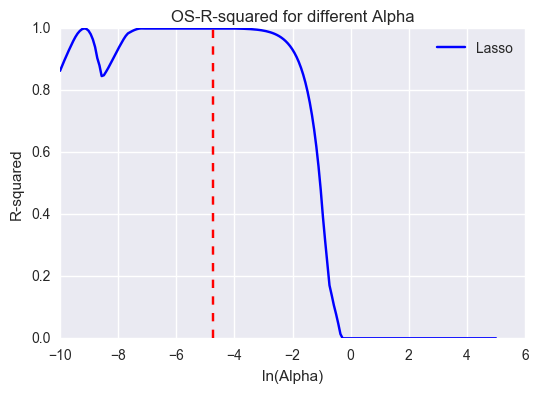

Optimal alpha for Lasso=0.008882980908164468


In [7]:
#fit Lasso for various alpha and tune it to optimize Validation R2

# define function for finding optimal alpha
def Regularization_fit_alpha(X_train,y_train,X_valid, y_valid, alphas,p=0.4,Graph=False, logl=False):
    
    RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
    model_label='Lasso'
    best_R2 = -1
    best_alpha = alphas[0]
    R_2_OS=[]
    
    for i in alphas:
        lm = RM(i)
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        err_OS=y_predict-y_valid
        R_2_OS_=1-np.var(err_OS)/np.var(y_valid)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_alpha = i
    
    if Graph==True:
        plt.title('OS-R-squared for different Alpha')
        if logl:
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return best_alpha

# Define predictors
lis_predictors=['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

# Define list of alphas
alphas=np.exp(np.linspace(-10,5,200))

# Find optimal alpha
alpha_l_optimal=Regularization_fit_alpha(data1[lis_predictors],data1['y'],data1_2[lis_predictors],data1_2['y'],alphas,p=0.4,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}'.format(alpha_l_optimal))

In [8]:
#report test R2

Lasso=linear_model.Lasso(fit_intercept=True,alpha=alpha_l_optimal)
Lasso.fit(data1[lis_predictors].append(data1_2[lis_predictors]),data1['y'].append(data1_2['y']))
p=Lasso.predict(data1_3[lis_predictors])
err=p-data1_3['y']
R_2_Lasso=1-np.var(err)/np.var(data1_3['y'])
print("The R-squared we found for test Lasso is: {0}".format(R_2_Lasso))


The R-squared we found for test Lasso is: 0.997315058957675


Lasso Coefficients [ 0.23308403  0.28095947  0.44738912  0.54727436  0.          0.01819468
  0.          0.          0.          0.        ]


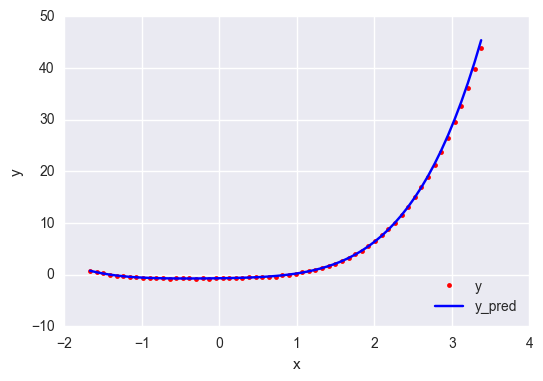

In [9]:
#visualize the model against all the data from training, validation and test samples
data=pd.DataFrame()
data=data.append(data1)
data=data.append(data1_2)
data=data.append(data1_3)
    
data['y_pred']=Lasso.predict(data[lis_predictors])

#data['x_original']=(data['x']*df_standard.loc[df_standard['Col']=='x','Std'][0])+df_standard.loc[df_standard['Col']=='x','Mean'][0]
#data['y_original']=(data['y']*df_standard.loc[df_standard['Col']=='y','Std'][0])+df_standard.loc[df_standard['Col']=='y','Mean'][0]
#data['y_pred_original']=(data['y_pred']*df_standard.loc[df_standard['Col']=='y','Std'][0])+df_standard.loc[df_standard['Col']=='y','Mean'][0]

#visualize the fit
#plt.plot(data.x_original,data.y_original,'.r') #plot the data
#plt.plot(data.x_original,data.y_pred_original,'b') #plot the regression
plt.plot(data.x,data.y,'.r') #plot the data
plt.plot(data.x,data.y_pred,'b') #plot the regression

plt.legend(loc='lower right')
#plt.ylim(700,2000)
plt.xlabel('x')
plt.ylabel('y')

print('Lasso Coefficients', Lasso.coef_)


### Question 2. P-values and hypothesis testing
Suppose that a multiple regression with 7 regressors gave the following p-values for each of them:
0.02, 0.1, 3e-15, 0.04, 0.001, 0.06, 0.03.

For how many regressors you would reject the null-hypothesis that their corresponding regression coefficient is zero at the 95% confidence level? Please explain.

Answer: We can reject the Null hypothesis for 5 regressors which have p-values 0.02,3e-15,0.04, 0.001 and 0.03.

For all these regressors p-value is smaller than the threshold of 0.05 which is required for 95% confidence interval.

### Question 3. Confidence intervals
Assume we perform a regression and get an estimate 10 for the slope coefficient for the regressor of interest. Select all statements that can not be true for its confidence intervals:

a. 95%-confidence interval is [-5, 5]

b. 99%-conficence interval is [9.99,10.01]

c. 95%-confidence interval is [9,100]

d. 99%-confidence interval is [8, 12], while 95%-confidence interval is [9, 11].

Explain your choices

Answer: All the above options are not true as confidence interval cannot be calculated only by the estimate for the slope coefficient. In addition to estimate for the slope coeffiecient we require the standard error to calculate the confidence interval.

# Principal component regression

### Question 4

Using the median price per sq.foot from Zillow data below as reported for 2018-08, fit the linear model using N leading principal components of the 311 data and perform cross-validation. Visualize performance depending on the number N of leading PCs. Specifically: 
    1. implement a 20-times-cross-validation as a function of N returing OS R2
    2. run it for N=1,2,...30, return the best N and the corresponding R2
    3. mark it with a vertical line on the plot and put the value of N and the corresponding R2 as text labels
**Important:** keep training pca over the training sample only, applying the same pca transform to the test samples in order to prepare regressors for them

In [10]:
# Write code here
zillow=pd.read_csv("data/Zip_MedianListingPricePerSqft_AllHomes.csv",index_col=0)

**Load/process 311 data**

In [11]:
data311 = pd.read_csv( 'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [12]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [13]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity
#data311=data311.reset_index()

In [14]:
# merge both the datas
data= data311.merge(zillow[['2018-07','2018-08']], left_index= True, right_index= True ,how='inner')
Y=data['2018-08']
data=data.drop(['2018-07','2018-08'], axis=1)

In [15]:
# define function to obtain optimum number of principal components for best Out of smaple R2
# by performing 20 fold cross validation

def pca_r2(data,Y,N, cv_folds, Graph=True):
    best_R2 = -1
    best_N = -1
    R_IS_Overall=[]
    R_OS_Overall=[]
    for npca in N:
        np.random.seed(0)
        # Apply cross-validation to diagnose model for overfitting
        R_IS=[]; R_OS=[] #lists for recording in-sample (training) and out-of-sample (test) R2
        n=cv_folds #number of runs
        for i in range(n):
            X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:],Y,test_size=0.3) #randomly split data into training (70%) and test (30%)
            #now apply PCA to the training data
            pca = PCA(npca) #take only N leading principal components to get enough data but avoid overfitting
            P_train=pca.fit_transform(X_train)
            res=smf.OLS(np.array(y_train),sm.add_constant(P_train)).fit()
            #and apply the same rotation transform we learned for training sample to the test sample
            #this is important that we learn PCA transform from the training sample only rather than from both - training and test
            #as this is part of the principle component regression we need to train; and all training should happen over the training set
            P_test=pca.transform(X_test)
            y_pred=np.array(res.predict(sm.add_constant(P_test)))
            #print(y_pred)
            #print(y_test)
            R_IS.append(res.rsquared)                                                                     
            err=y_pred-np.array(y_test)
            R_OS.append(1-((y_pred-np.array(y_test))**2).sum()/((np.array(y_test)-np.mean(np.array(y_test)))**2).sum())    
        R_IS_Overall.append(np.mean(R_IS))
        R_OS_Overall.append(np.mean(R_OS))
        if np.mean(R_OS) > best_R2:
            best_R2 = np.mean(R_OS)
            best_N = npca
    print("The optimum number of Principal Component are: ", best_N)
    print("The best OS-R-squared is: ", best_R2)
    
    if Graph==True:
        plt.title('OS-R-squared for different N')
        plt.xlabel('Number of Principal Component')
        plt.plot(N,R_OS_Overall,'b',label='20 Fold CV_Score')
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(best_N,color='r',linestyle='--')

        plt.show()

The optimum number of Principal Component are:  16
The best OS-R-squared is:  0.821194145081


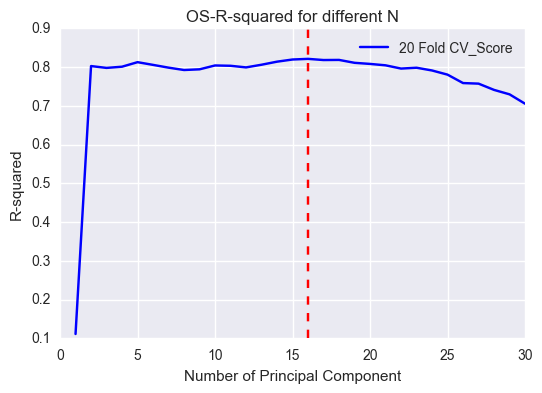

In [16]:
# run the function
pca_r2(data,Y,list(range(1,31)), 20, Graph=True)

### Question 5
1. Using the Zillow dataset from question 4, run PCA on the price dynamics for zip codes over the last 5 years 
    1. take only those zip codes within NYC having price defined for the last 60 months from 2013-09 till 2018-08:
    2. normalize each zip code timeline by average price over this period
    3. standardize those normalized prices per month and use them as features
    4. run pca over those features

2. Visualize zip codes in the 2d space of first two principal components, coloring them by borough (feel free to use borough definition from the class notebook). 

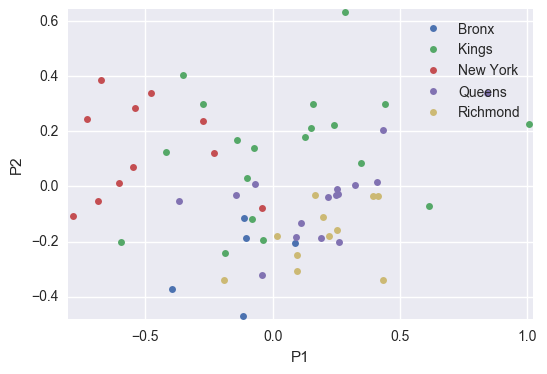

In [17]:
# Subset data with required rows and columns
zillow_new=zillow.loc[zillow['City']=='New York',['City', 'State', 'Metro', 'CountyName', 'SizeRank'] + list(zillow)[-60:]]

# drop na values
zillow_new = zillow_new.dropna()

# normalize rows by last 60 months average
zillow_new[list(zillow_new)[-60:]]=zillow_new[list(zillow_new)[-60:]].div(zillow_new[list(zillow_new)[-60:]].mean(axis=1), axis=0) #normalize activity of various cathegories within zip code by total

# Standardize month columns
for c in list(zillow_new)[-60:]:
    zillow_new[c]=zillow_new[c]-zillow_new[c].mean()/zillow_new[c].std()

# Apply PCA and obtain first 2 principal components    
pca = PCA(len(list(zillow_new)[-60:]))
P_train=pca.fit_transform(zillow_new[list(zillow_new)[-60:]])
zillow_new['P1']=P_train[:,0]
zillow_new['P2']=P_train[:,1]

# Plot first 2 principal component and color as per borough name
groups =zillow_new.groupby('CountyName')
fig, ax = plt.subplots()
ax.margins(0.01) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.P1, group.P2, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.xlabel('P1')
plt.ylabel('P2')
plt.show()
